In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
path =r'..\\data'
epl1819 = pd.read_csv(path+"\\football-data EPL 18-19.csv")
epl1920 = pd.read_csv(path+"\\football-data EPL 19-20.csv")
epl2021 = pd.read_csv(path+"\\football-data EPL 20-21.csv")
dataset = pd.concat([epl1819, epl1920, epl2021])
dataset.reset_index(inplace=True)
dataset = dataset[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]]
dataset

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,10/08/2018,Man United,Leicester,2,1,H
1,11/08/2018,Bournemouth,Cardiff,2,0,H
2,11/08/2018,Fulham,Crystal Palace,0,2,A
3,11/08/2018,Huddersfield,Chelsea,0,3,A
4,11/08/2018,Newcastle,Tottenham,1,2,A
...,...,...,...,...,...,...
1135,23/05/2021,Liverpool,Crystal Palace,2,0,H
1136,23/05/2021,Man City,Everton,5,0,H
1137,23/05/2021,Sheffield United,Burnley,1,0,H
1138,23/05/2021,West Ham,Southampton,3,0,H


In [3]:
dataset

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,10/08/2018,Man United,Leicester,2,1,H
1,11/08/2018,Bournemouth,Cardiff,2,0,H
2,11/08/2018,Fulham,Crystal Palace,0,2,A
3,11/08/2018,Huddersfield,Chelsea,0,3,A
4,11/08/2018,Newcastle,Tottenham,1,2,A
...,...,...,...,...,...,...
1135,23/05/2021,Liverpool,Crystal Palace,2,0,H
1136,23/05/2021,Man City,Everton,5,0,H
1137,23/05/2021,Sheffield United,Burnley,1,0,H
1138,23/05/2021,West Ham,Southampton,3,0,H


In [4]:
# Create a unique code for each team
teams = dataset["HomeTeam"].unique()
teams = np.sort(teams)
n_teams = len(teams)
team_codes = [i for i in range(0, n_teams)]
team_codes_map = dict(zip(teams, team_codes))

# Add this unique code to the df
dataset["HomeTeamCode"] = dataset["HomeTeam"].apply(lambda x: team_codes_map[x])
dataset["AwayTeamCode"] = dataset["AwayTeam"].apply(lambda x: team_codes_map[x])

# Create pymc3 input: an array of home team codes, away team codes, home team goals, away team goals
home_goals = dataset["FTHG"].values
away_goals = dataset["FTAG"].values
home_team_code = dataset["HomeTeamCode"].values
away_team_code = dataset["AwayTeamCode"].values

# Model Specification
**Hyper Priors:**  
mu_att ~ Normal(0, 0.0001)  
mu_def ~ Normal(0, 0.0001)  
tau_att ~ Gamma(0.1, 0.1)  
tau_def ~ Gamma(0.1, 0.1)  

**Priors:**  
home ~ Normal(mean=0, precision=0.0001)  
att[i] ~ Normal(mu_att, tau_att)  
def[i] ~ Normal(mu_def, tau_def)  

**Determinsitic Transform:**  
theta_g1[g] = exp(home + att[i] + def[i])
theta_g2[g] = exp(att[i] + def[i])

**Likelihood:**  
yg1[g] ~ Poisson(theta_g1[g])
yg2[g] ~ Poisson(theta_g2[g])

In [5]:
with pm.Model() as model:
    
    # Hyper-priors
    #μ_att = pm.Normal('μ_att', mu=0., tau=0.0001)
    #μ_def = pm.Normal('μ_def', mu=0., tau=0.0001)
    
    τ_att = pm.Gamma('τ_att', 0.1, 0.1)
    τ_def = pm.Gamma('τ_def', 0.1, 0.1)    
    
    # Priors
    home = pm.Normal('home', mu=0., tau=0.0001)
    att_ = pm.Normal('att_', mu=0, tau=τ_att, shape=n_teams)
    deff_ = pm.Normal('deff_', mu=0, tau=τ_def, shape=n_teams)
    
    # Sum to 0 Constraint
    att = pm.Deterministic('att', att_ - tt.mean(att_))
    deff = pm.Deterministic('deff', deff_ - tt.mean(deff_))
    
    # Deterministic Transform
    θ_1 = tt.exp(att[home_team_code] + deff[away_team_code] + home)
    θ_2 = tt.exp(att[away_team_code] + deff[home_team_code])
    
    # Likelihood
    y_1 = pm.Poisson('y_1', mu=θ_1, observed=home_goals)
    y_2 = pm.Poisson('y_2', mu=θ_2, observed=away_goals)
    
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [deff_, att_, home, τ_def, τ_att]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 130 seconds.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\benja\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'home'}>,
        <AxesSubplot:title={'center':'home'}>],
       [<AxesSubplot:title={'center':'att_'}>,
        <AxesSubplot:title={'center':'att_'}>],
       [<AxesSubplot:title={'center':'deff_'}>,
        <AxesSubplot:title={'center':'deff_'}>],
       [<AxesSubplot:title={'center':'τ_att'}>,
        <AxesSubplot:title={'center':'τ_att'}>],
       [<AxesSubplot:title={'center':'τ_def'}>,
        <AxesSubplot:title={'center':'τ_def'}>],
       [<AxesSubplot:title={'center':'att'}>,
        <AxesSubplot:title={'center':'att'}>],
       [<AxesSubplot:title={'center':'deff'}>,
        <AxesSubplot:title={'center':'deff'}>]], dtype=object)

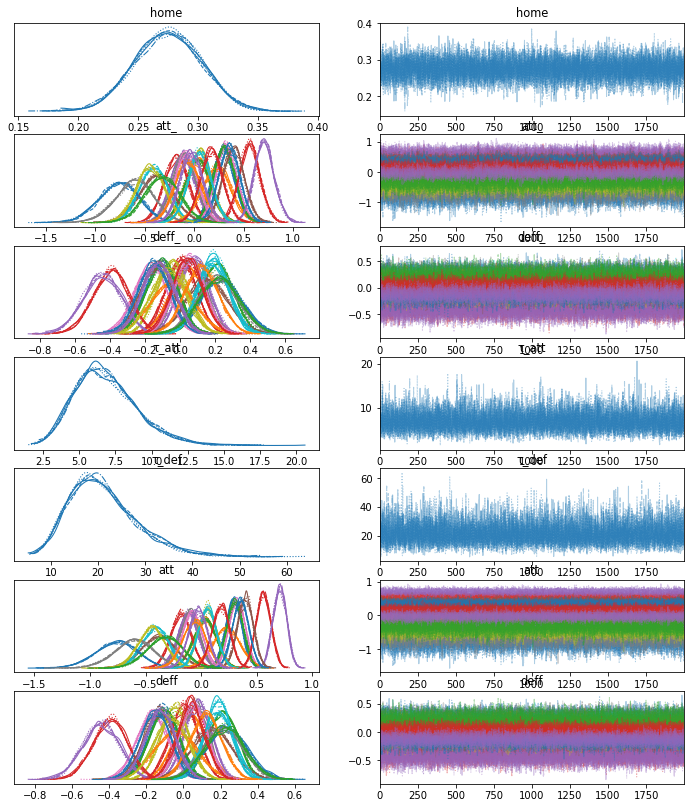

In [6]:
az.plot_trace(trace)

In [7]:
summary_trace = az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\benja\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


### Table 2: Estimation of the main effects for the loglinear model

In [8]:
def index_to_team_param(x):
    num = int(x.split('[')[1].split(']')[0])
    team_name = list(team_codes_map.keys())[list(team_codes_map.values()).index(num)]
    return team_name

In [9]:
summary_trace = summary_trace[["mean", "sd", "hdi_3%", "hdi_97%"]]

att_param_rows = summary_trace.iloc[-n_teams*2:-n_teams]
deff_param_rows = summary_trace.iloc[-n_teams:]
home_row = summary_trace.iloc[:1]

deff_param_rows.index = deff_param_rows.index.map(index_to_team_param)
att_param_rows.index = att_param_rows.index.map(index_to_team_param)

table_2 = att_param_rows.join(deff_param_rows, lsuffix='_a', rsuffix='_d')
table_2

,mean_a,sd_a,hdi_3%_a,hdi_97%_a,mean_d,sd_d,hdi_3%_d,hdi_97%_d
Arsenal,0.292,0.074,0.147,0.427,-0.110,0.079,-0.256,0.038
Aston Villa,0.036,0.103,-0.155,0.227,0.037,0.088,-0.122,0.201
Bournemouth,0.032,0.101,-0.160,0.222,0.211,0.082,0.054,0.359
Brighton,-0.182,0.091,-0.355,-0.012,0.003,0.074,-0.137,0.140
Burnley,-0.119,0.091,-0.293,0.046,0.078,0.073,-0.064,0.208
Cardiff,-0.386,0.157,-0.683,-0.087,0.154,0.111,-0.057,0.363
Chelsea,0.322,0.074,0.182,0.459,-0.169,0.083,-0.322,-0.013
Crystal Palace,-0.103,0.088,-0.268,0.061,0.057,0.073,-0.077,0.194
Everton,0.055,0.083,-0.095,0.213,-0.046,0.076,-0.191,0.096
Fulham,-0.412,0.123,-0.647,-0.181,0.187,0.083,0.038,0.348


In [10]:
home_row

,mean,sd,hdi_3%,hdi_97%
home,0.275,0.028,0.222,0.324
